In [ ]:
pip install opencv-python

In [2]:
#라이브러리 호출
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
import numpy as np
np.bool = bool  # Replace np.bool with the built-in bool

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#RandomResizedCrop
!pip install mxnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [ ]:
!pip install --upgrade mxnet

In [ ]:
!pip install mxnet==1.9.1

In [ ]:
import mxnet as mx

In [4]:
#이미지 데이터 전처리 방법 정의
data_path = '/content/drive/MyDrive/Euron/catanddog/train'

##이미지 데이터를 변환하여 모델(네트워크)의 입력으로 사용할 수 있도록 변환해줌
transform = transforms.Compose(
    [
        transforms.Resize([256,256]), # 이미지의 크기를 256*256으로 조정 - 합성곱층을 통과하기 위해 이미지 크기를 조정하는 전처리 과정
        transforms.RandomResizedCrop(224), #이미지를 랜덤한 크기 및 비율로 자름. 데이터 확장 용도로 사용됨.
        transforms.RandomHorizontalFlip(), #이미지를 랜덤하게 수평으로 뒤집음
        transforms.ToTensor() # 이미지를 텐서로 변환함
])

train_dataset = torchvision.datasets.ImageFolder( #데이터로더가 데이터를 불러올 대상과 방법을 정의
    data_path, # 불러올 데이터가 위치한 경로
    transform = transform # 위의 전처리 과정. 이미지 데이터에 대한 전처리.
)

train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=32,
                num_workers = 8,
                shuffle = True
)

print(len(train_dataset))

385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


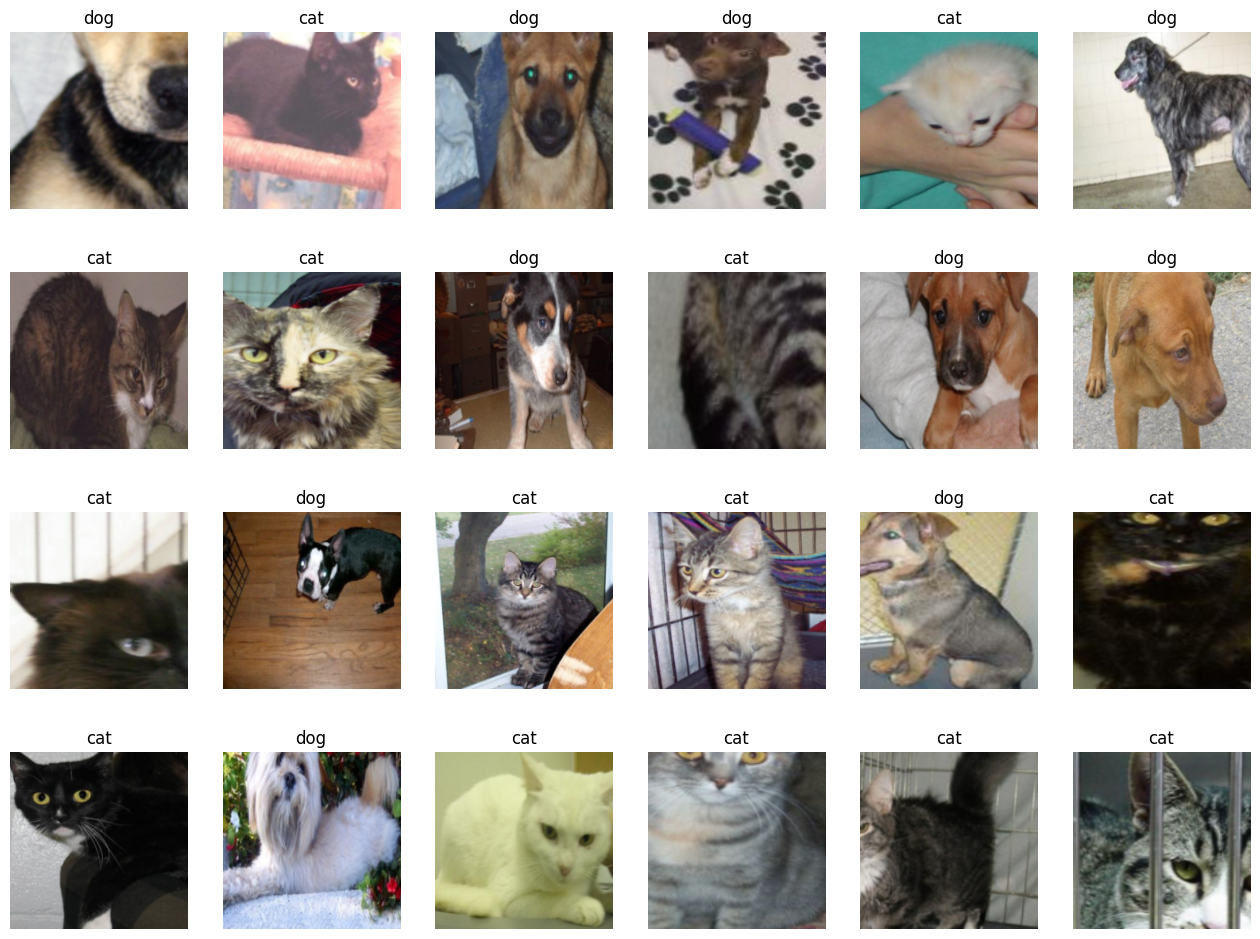

In [6]:
samples, labels = next(iter(train_loader)) #next -> 반복자가 다음에 출력해야 할 요소를 반환. train loader에서 samples와 labels의 값을 순차적으로 꺼내서 저장
classes = {0:'cat', 1: 'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
  a = fig.add_subplot(4, 6, i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) #np.transpose -> 행과 열을 바꾸어 행렬의 차원을 바꿔줌 (행렬의 내적 연산을 위해서 시행함.)
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

In [7]:
resnet18 = models.resnet18(pretrained = True)
#50개의 계층으로 구성된 합성곱 신경망. imagenet 데이터베이스의 100만 개가 넘는 영상을 이용하여 훈련된 신경망.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


In [8]:
#사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting = True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False #역전파의 과정에서 파라미터들에 대한 변화를 계산할 필요가 없음. 적용되는 부분은 합성곱층과 풀링층

set_parameter_requires_grad(resnet18)

In [9]:
#ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512,2) #2 -> 클래스가 2개다.

In [11]:
#모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[ 0.0144,  0.0002, -0.0338,  ..., -0.0331, -0.0428,  0.0362],
        [ 0.0024, -0.0277, -0.0167,  ...,  0.0234,  0.0211, -0.0335]])
fc.bias tensor([ 0.0423, -0.0389])


In [12]:
#모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained = True)

for param in model.parameters():
  param.requires_grad = False

model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
import os
import time

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()  # Get the current time
    acc_history = []
    loss_history = []
    best_acc = 0.0

    # Specify the path to the 'Cat' folder
    cat_folder = '/content/drive/MyDrive/Euron/train/Cat'

    # Create the folder if it doesn't exist
    os.makedirs(cat_folder, exist_ok=True)

    for epoch in range(num_epochs):  # Loop through epochs
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:  # Loop through the data in dataloaders
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()  # Set gradients to zero
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()  # Backward pass
            optimizer.step()

            # Accumulate loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)  # Average loss
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)  # Average accuracy

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        # Save the model to the 'Cat' folder with a filename that includes the epoch
        torch.save(model.state_dict(), os.path.join(cat_folder, 'model_epoch_{}.pt'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history


In [14]:
#파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad ==True:
    params_to_update.append(param) #파라미터 학습 결과 저장
    print("/t", name)

optimizer = optim.Adam(params_to_update)

/t fc.weight
/t fc.bias


In [15]:
import os
os.path.exists('/content/drive/MyDrive/Euron/train/Cat')

True

In [16]:
#모델 학습
device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5903 Acc: 0.6623

Epoch 1/12
----------
Loss: 0.3683 Acc: 0.8701

Epoch 2/12
----------
Loss: 0.2839 Acc: 0.9143

Epoch 3/12
----------
Loss: 0.2872 Acc: 0.8883

Epoch 4/12
----------
Loss: 0.2460 Acc: 0.9013

Epoch 5/12
----------
Loss: 0.2263 Acc: 0.9091

Epoch 6/12
----------
Loss: 0.2733 Acc: 0.8753

Epoch 7/12
----------
Loss: 0.3114 Acc: 0.8571

Epoch 8/12
----------
Loss: 0.1766 Acc: 0.9429

Epoch 9/12
----------
Loss: 0.2249 Acc: 0.8987

Epoch 10/12
----------
Loss: 0.2172 Acc: 0.9013

Epoch 11/12
----------
Loss: 0.2237 Acc: 0.9143

Epoch 12/12
----------
Loss: 0.1952 Acc: 0.9117

Training complete in 10m 5.351485s
Best Acc: 0.942857


In [17]:
#테스트 데이터 호출 및 전처리
test_path = '/content/drive/MyDrive/Euron/catanddog/test'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
])

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 1,
    shuffle = True
)

print(len(test_dataset))

98


In [ ]:
since = time.time()
best_acc = 0.0

In [18]:
def eval_model(model, dataloaders, device):
    since = time.time()  # Start time
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/Euron/catanddog' + '*.pth')
    saved_models.sort()  # Sort .pth files alphabetically
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:  # Testing loop
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():  # Disable gradient computation
                outputs = model(inputs)  # Get model outputs

                _, preds = torch.max(outputs.data, 1)
                preds[preds >= 0.5] = 1  # Set predictions to 1 if >= 0.5
                preds[preds < 0.5] = 0   # Set predictions to 0 if < 0.5
                running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            acc_history.append(epoch_acc.item())
            print()

    time_elapsed = time.time() - since  # Time elapsed should be inside the function
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history  # 'return' should be inside the function


In [ ]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 0.8469

Loading model catanddog/01.pth
Acc: 0.8878

Loading model catanddog/02.pth
Acc: 0.9286

Loading model catanddog/03.pth
Acc: 0.9286

Loading model catanddog/04.pth
Acc: 0.9388

Loading model catanddog/05.pth
Acc: 0.9286

Loading model catanddog/06.pth
Acc: 0.9388

Loading model catanddog/07.pth
Acc: 0.9184

Loading model catanddog/08.pth
Acc: 0.9286

Loading model catanddog/09.pth
Acc: 0.9184

Loading model catanddog/10.pth
Acc: 0.9286

Loading model catanddog/11.pth
Acc: 0.9184

Loading model catanddog/12.pth
Acc: 0.9184

Validation complete in 0m 8s
Best Acc: 0.938776


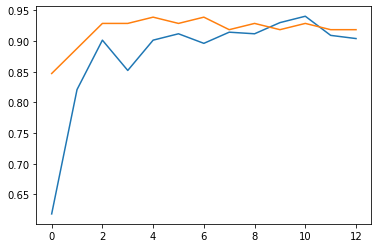

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

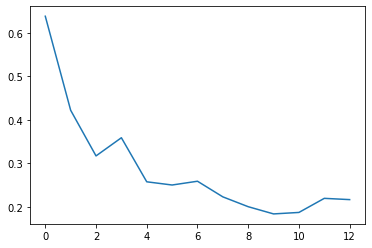

In [ ]:
plt.plot(train_loss_hist)
plt.show()

In [20]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

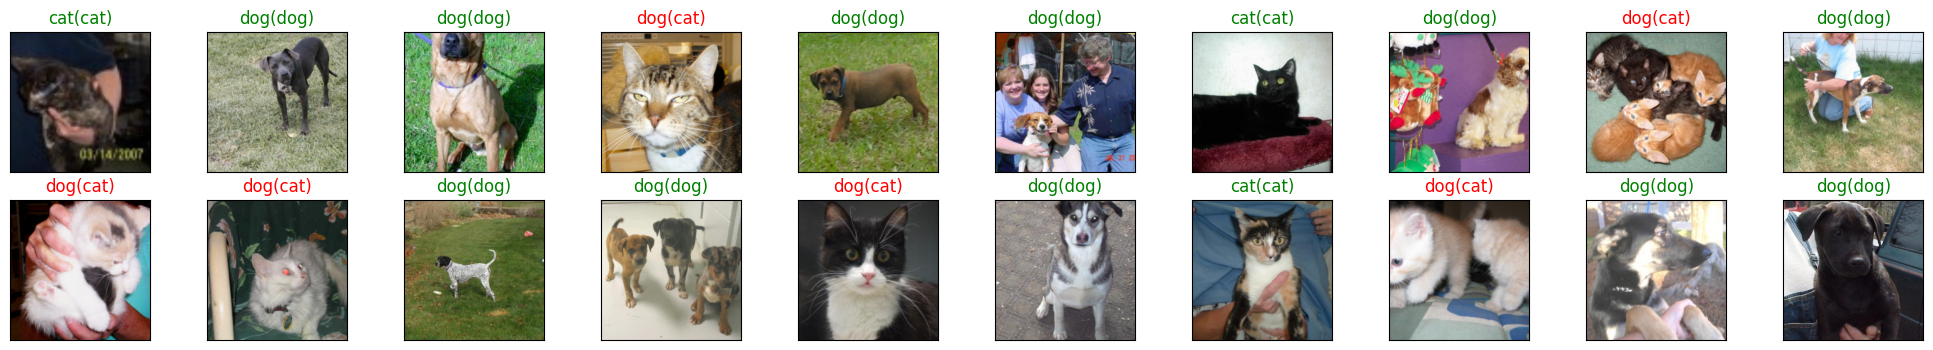

<Figure size 640x480 with 0 Axes>

In [22]:
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)

output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

##특성 맵 시각화

In [26]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as tranforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),  # inplace=True는 기존의 데이터를 덮어씀
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [30]:
# 모델 객체화
model = XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [ ]:
#특성 맵을 확인하기 위한 클래스 정의
class LayerActivations:
    def __init__(self, model, layer_num):
        self.features = []
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output.detach().cpu().numpy()

    def remove(self):
        self.hook.remove()


torch.Size([1, 3, 100, 100])


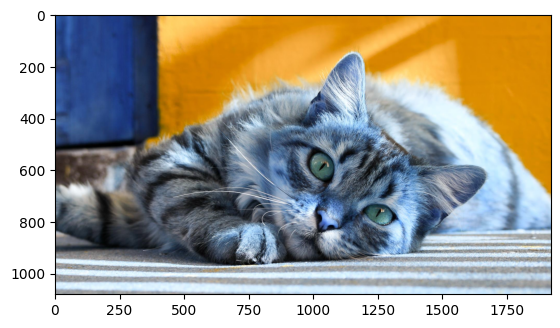

In [ ]:
#이미지 호출
img = cv2.imread("/content/drive/MyDrive/Euron/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100,100), interpolation = cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [ ]:
result = LayerActivations(model.features, 0)
model(img)
activations = result.features

<ipython-input-3-5979313a8665>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


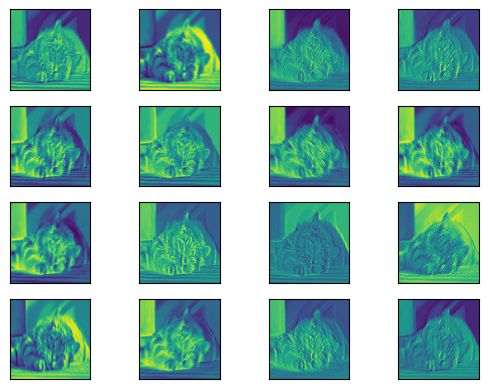

<Figure size 1200x800 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [ ]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

<ipython-input-3-5979313a8665>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


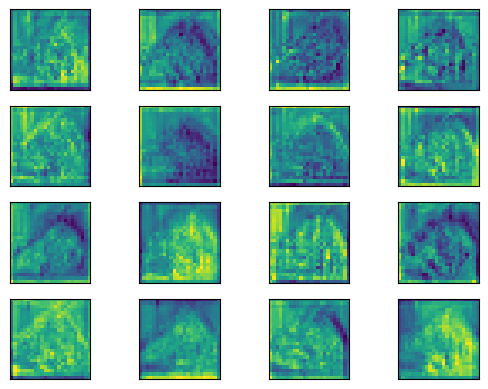

<Figure size 1200x800 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [ ]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

<ipython-input-3-5979313a8665>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


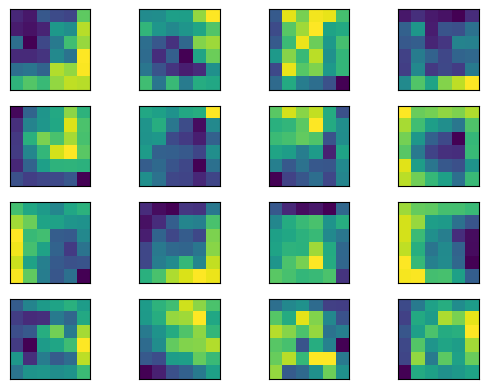

<Figure size 1200x800 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()